#Predicting Protein Interaction using GCNs on Yeast Dataset

## It is very interesting to predict the protein protein interection using GCN (Graph Convoultion Network) 

#### In this note book we will not discuss in details about the GCN, but if one is interested then can refer articel by Thomas Knief [Link](https://tkipf.github.io/graph-convolutional-networks/).

**Note:** This notebook uses CUDA v.10.1. If your PC is not supported, run this notebook on Colab with GPU settings turned on.
Specifically this .ipynb is executed on google Colab

### Outline of note book

<ol>
<li> Importing or installing required libraries. 
<li> Load the dataset. 
<li> Clean the data if needed.
<li> Split our data into training, validation, and testing.
<li> Define our Neural netowrk. 
<li> Tuning our model on the validation dataset.
<li> Measuring performance of the model.  
</ol>

##### 1. Installing and importing some important packages 
* Stellergraph 
* dgl (Deep Graph Library)
* Networkx 
* Torch(Pytorch)
* Sklearn
* Dataset
* Dataloader
* Numpy
* Pandas
* Seaborn
* Matplotlib


In [ ]:
!pip install dgl-cu101

In [ ]:
!pip install stellargraph

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.sparse as sp
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,precision_recall_curve,confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,average_precision_score, accuracy_score
from torch.utils.data import Dataset,DataLoader
from torch.autograd import Variable
from stellargraph.data import EdgeSplitter
from pylab import savefig
from matplotlib import pyplot

In [ ]:
import dgl
from dgl import DGLGraph
dgl.load_backend('pytorch')
from dgl.nn.pytorch import conv as dgl_conv

Using backend: pytorch


#### 2. Load the dataset

###### We have uploaded our dataset on google drive. So, we are accesing our dataset from there. 
for that we are mounting google drive as shown below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 3. Clean the data if needed
To see if there is any cleaning required or not?

We will look into the dataset and explore it to know more about it. 

In [ ]:
raw_edge_list = open('/content/drive/My Drive/Project/yeast.edgelist','r')
G = nx.Graph()
G = nx.parse_edgelist(raw_edge_list, delimiter='\t', create_using=G,nodetype=str, data=(('weight', float),))
# Get graph edges and nodes from networkx graph object
nodes = G.nodes
edges = G.edges

print("Graph's Nodes : {} / Edges : {}".format(len(nodes), len(edges)))

Graph's Nodes : 6526 / Edges : 532180


In [ ]:
G = nx.relabel.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute=None)

In [ ]:
# G.remove_edges_from(nx.selfloop_edges(G))

From the above analysis, it is clear that our data is clean. So, we do not need to clean it.<br> We have also converted our node label to integers so that it will be easy to make the computation.

Now let us move onto the next step called data-splitting.

#### 4. Split our data into training, validation, and testing.

Here we would like to split our data into training, testing, and validation set.<br>
For this splitting, we are using the Edgesplitter library.<br>  

In [ ]:
es_test = EdgeSplitter(G)
graph_test, examples_test, link_labels_test = es_test.train_test_split(p=0.025, method="global")

** Sampled 133045 positive and 133045 negative edges. **


In [ ]:
es_train = EdgeSplitter(graph_test, G)
graph_train, examples_train, link_labels_train = es_train.train_test_split(
    p=0.25, method="global")
examples_train,examples_val, link_labels_train, link_label_val = train_test_split(
    examples_train, link_labels_train, test_size=0.1, random_state = 20200226, 
    stratify= link_labels_train)

** Sampled 99783 positive and 99783 negative edges. **


In [ ]:
# edge_splitter_train = EdgeSplitter(graph_test, graph)
# graph_train, examples, labels = edge_splitter_train.train_test_split(p=0.1, method="global")
# (examples_train, examples_model_selection, labels_train,labels_model_selection,) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

In [ ]:
print(len(examples_test))
print(len(link_labels_test))
print(len(examples_train))
print(len(examples_val))
print(len(link_labels_train))
print(len(link_label_val))

266090
266090
179609
19957
179609
19957


In [ ]:
torch.cuda.get_device_name(0)

'Tesla K80'

**Feature matrix**<br>
For our neural network inputs, we are using a feature matrix. <br> Since we are using PyTorch and working with the tensor, we have created such a sparse matrix as shown in the function below.

In [ ]:
def preprocess_graph(adj):
  adj = sp.coo_matrix(adj)
  adj_ = adj + sp.eye(adj.shape[0])
  rowsum = np.array(adj_.sum(1))
  degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
  features = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo() 
  print(features.shape)

  print(type(features))

  indices = np.vstack((features.row, features.col))
  values = features.data
  shape = features.shape
  i = torch.LongTensor(indices)
  v = torch.FloatTensor(values)

  features = torch.sparse.FloatTensor(i, v, torch.Size(shape)).to_dense()
  return features

In [ ]:
features = preprocess_graph(nx.adjacency_matrix(graph_train))


(6526, 6526)
<class 'scipy.sparse.coo.coo_matrix'>


Pytorch provides dataset which will be helpful to access large file such that it can be used for multiprocessing 

In [ ]:
class EdgeDataset(Dataset):
    def __init__(self, x, y):
        super(EdgeDataset, self).__init__()
        assert x.shape[0] == y.shape[0] # assuming shape[0] = dataset size
        self.x = x
        self.y = y
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

#### 5. Define our Neural netowrk

Here we are using Graph convolution network so our neural network will cosist GCN. <br> We are generating NN as shown in code below: <br>
We are using four different layers for NN their order is as below:
* GCN layer 1
* GCN layer 2
* Linear layer 1
* Linear layer 2
<br>
<b>Note:</b> Please keep the track of dimension of layers. 

In [ ]:
class GCNModel(nn.Module):
    def __init__(self, inl_dim, hl1_dim, hl2_dim, opl_dim):
        super(GCNModel, self).__init__()
        

        self.gcn_layer_1 = dgl_conv.GraphConv(inl_dim, hl1_dim)

        self.gcn_layer_2 = dgl_conv.GraphConv(hl1_dim, hl2_dim)

        self.lin_layer_1 = nn.Linear(hl2_dim, opl_dim)

        self.lin_layer_2 = nn.Linear(opl_dim,1)

    def forward(self, g, features, node_pairs, link_labels): 
        x = features
        x = self.gcn_layer_1(g, features)
        x = F.relu(x)

        x = self.gcn_layer_2(g,x)
        x = F.relu(x)

        src = node_pairs[:,0]
        dst = node_pairs[:,1]

        emb_src = x[src]
        emb_dst = x[dst]

        # z_tensor = torch.mul(emb_src,emb_dst)  # Hadamard
        z_tensor = (emb_src - emb_dst) / 2.0
        # z_tensor = torch.abs(emb_src - emb_dst)  # weighted l1
        z_tensor = self.lin_layer_1(z_tensor)
        z_tensor = F.relu(z_tensor)
        z_tensor = self.lin_layer_2(z_tensor)
        sigm = nn.Sigmoid()
        z_tensor = sigm(z_tensor)
        return z_tensor.view(-1)
    
    def predict(self, g, features, node_pairs, link_labels):
        pred = self.forward(g, features, node_pairs, link_labels)
        loss = nn.BCELoss()(pred, link_labels)
        return loss, pred


#### Create and train model 
In the function defined below we are traing our model.

In [ ]:
def create_model_and_train(inl_dim, hl1_dim, hl2_dim, opl_dim, batch_size, lr, n_epochs):
  g = dgl.from_networkx(graph_train)
  g = dgl.add_self_loop(g)
  g.readonly()
  model = GCNModel(inl_dim = inl_dim, hl1_dim = hl1_dim,
                   hl2_dim = hl2_dim, opl_dim = opl_dim)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  traindata = EdgeDataset(examples_train, link_labels_train)
  edge_loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
  print("Training for {} epochs.".format(n_epochs))

  eval_report = {
      'train_losses':[],
      'train_rocs':[],
      'train_aps':[],
      'train_acs' :[],
      'val_losses':[],
      'val_rocs':[],
      'val_aps':[],
      'val_acs':[],
      'times_per_epoch':[],
      'epochs':[],
      'learning_rate': list(np.full((n_epochs,),lr)),
      'batch_size':list(np.full((n_epochs,),batch_size)),
      'hidden1_dim':list(np.full((n_epochs,),hl1_dim)) ,
      'hidden2_dim':list(np.full((n_epochs,),hl2_dim)) ,
      'opl_dim':list(np.full((n_epochs,),opl_dim))
  }

  sigm_val_pred = []
  for epoch in range(n_epochs):
    eval_report['epochs'].append(epoch+1)
    t = time.time()
    print('\n', end='')
    
    loss = 0.0
    train_roc = 0.0
    train_ap = 0.0
    for i,data in enumerate(edge_loader):

      pairs, edges = data
      pairs = Variable(pairs).cuda()
      edges = Variable(edges.float()).cuda()
      
      optimizer.zero_grad()
      loss, pred = model.predict(g.to(device), torch.FloatTensor(features).cuda(), pairs, edges)
      # loss, pred = model.predict(g, torch.FloatTensor(features).cuda(), pairs, edges)
      loss.backward()
      optimizer.step()

      pred = pred.detach().to("cpu").numpy()
      y_pred = []
      y_pred = np.append(y_pred, pred)
      train_roc = roc_auc_score(edges.detach().to("cpu").numpy(), y_pred)
      train_ap = average_precision_score(edges.detach().to("cpu").numpy(), y_pred)
      train_ac = accuracy_score(edges.detach().to("cpu").numpy(), y_pred.round())
      print("\repoch = {}/{} ({}/{}) - loss = {:.4f} roc_auc_score = {:.4f} train_ac = {:.4f} "
      .format(epoch+1,n_epochs,i+1,int(examples_train.shape[0]/batch_size),
              loss,train_roc, train_ac),end='',flush=True)
  
    eval_report['train_losses'].append(float(loss.detach().to('cpu').numpy()))
    eval_report['train_rocs'].append(train_roc)
    eval_report['train_aps'].append(train_ap)
    eval_report['train_acs'].append(train_ac)
    


    val_loss, val_pred = model.predict(g.to(device),torch.FloatTensor(features).cuda(), 
                                      torch.tensor(examples_val).cuda(), 
                                      torch.FloatTensor(link_label_val).cuda())
    val_pred = val_pred.detach().to("cpu").numpy()
    sigm_val_pred = val_pred
    val_y_pred = []
    val_y_pred = np.append(val_y_pred, val_pred)
    val_roc = roc_auc_score(link_label_val, val_y_pred)
    val_ap = average_precision_score(link_label_val, val_y_pred)
    val_ac = accuracy_score(link_label_val, val_y_pred.round())
    
    eval_report['val_losses'].append(float(val_loss.detach().to('cpu').numpy()))
    eval_report['val_rocs'].append(val_roc)
    eval_report['val_aps'].append(val_ap)
    eval_report['val_acs'].append(val_ac)
    eval_report['times_per_epoch'].append(float(time.time()-t))

    print("\repoch = {}/{} - loss = {:.4f} roc_auc_score = {:.4f} val_loss = {:.4f} val_roc_auc_score = {:.4f} val_avg_precision = {:.4f} time= {:.5f}"
    .format(epoch+1,n_epochs,loss,train_roc,val_loss,val_roc,val_ap, time.time()-t),end='',flush=False)
  return model,eval_report,sigm_val_pred

#### 6. Tuning our model using the split dataset 

**Set Hyperparameters:** <br>
Hyperparameters are the vital knob for training our model, whichaids to find out the best performing model. They can be chosen heuristically from certain numbers since there is a no specific for-mula to choose them. Performance of the model varies accordingto these hyperparameters. Henceforth, we can change these param-eters and find it out that for which of them our model is providingthe best performance.

In [ ]:
inl_dim = features.shape[0]
hl1_dim = 512
hl2_dim = 128
opl_dim = 256
batch_size = 64
lr = 0.001
n_epochs = 24

Training start 

In [ ]:
model, eval_report, sigmoid_val_pred = create_model_and_train(inl_dim, 
                                                              hl1_dim,
                                                              hl2_dim,
                                                              opl_dim,
                                                              batch_size,
                                                              lr, 
                                                              n_epochs)
#append_to_csv(eval_report)

Training for 24 epochs.

epoch = 1/24 (1/2806) - loss = 0.6903 roc_auc_score = 0.5438 train_ac = 0.5469 

/usr/local/lib/python3.6/dist-packages/dgl/base.py:45: DGLWarning: DGLGraph.readonly is deprecated in v0.5.
DGLGraph now always supports mutable operations like add_nodes and add_edges.
  return warnings.warn(message, category=category, stacklevel=1)


epoch = 1/24 - loss = 0.3682 roc_auc_score = 0.9487 val_loss = 0.4559 val_roc_auc_score = 0.8698 val_avg_precision = 0.8524 time= 330.05163
epoch = 2/24 - loss = 0.3856 roc_auc_score = 0.9097 val_loss = 0.4292 val_roc_auc_score = 0.8831 val_avg_precision = 0.8689 time= 330.64993
epoch = 3/24 - loss = 0.4778 roc_auc_score = 0.8400 val_loss = 0.4215 val_roc_auc_score = 0.8897 val_avg_precision = 0.8770 time= 330.65950
epoch = 4/24 - loss = 0.2933 roc_auc_score = 0.9359 val_loss = 0.4131 val_roc_auc_score = 0.8942 val_avg_precision = 0.8813 time= 330.67654
epoch = 5/24 - loss = 0.3618 roc_auc_score = 0.9295 val_loss = 0.4054 val_roc_auc_score = 0.8981 val_avg_precision = 0.8861 time= 330.56077
epoch = 6/24 - loss = 0.3899 roc_auc_score = 0.9221 val_loss = 0.3998 val_roc_auc_score = 0.9011 val_avg_precision = 0.8888 time= 330.37513
epoch = 7/24 - loss = 0.3368 roc_auc_score = 0.9416 val_loss = 0.4201 val_roc_auc_score = 0.8905 val_avg_precision = 0.8702 time= 330.24990
epoch = 8/24 - loss 

#### 7. Measuring the performance of the model
To find out the performance of the model for unseen testing data, we are considering evaluation matrices such as CM, ROC curve, ROC AUC score, PR curve, and AP score. These scores are discussed below for the test dataset. 

**Note:** Since our program was computationally lengthy we were not able to use the cross-validation technique. To come over that we have stored performance scores in the Datafrme and from that, we have decided our best setting for hyperparameters.

In [ ]:
testdata = EdgeDataset(examples_test,link_labels_test)
test_loader = DataLoader(testdata, batch_size, shuffle=False)

In [ ]:
g_test = dgl.from_networkx(graph_test)
g_test = dgl.add_self_loop(g_test)
# g_test.from_networkx(graph_test)
g_test.readonly()
test_preds = []
test_true = []
test_losses = []
for i,Data in enumerate(test_loader):
  node_pairs, labels_test = Data
  with torch.no_grad():
    test_loss, test_pred = model.predict(g_test.to(device),
                                         torch.FloatTensor(features).cuda(), 
                                         torch.tensor(node_pairs).cuda(), 
                                         labels_test.float().cuda())
    
    test_losses.append(test_loss)
    test_pred = test_pred.detach().to("cpu").numpy()
    test_preds = np.append(test_preds, test_pred)
    test_true = np.append(test_true,labels_test)

In [ ]:

test_roc = roc_auc_score(test_true, test_preds)
test_ap = average_precision_score(test_true,test_preds)
test_ac = accuracy_score(test_true, test_preds.round())
print("Test ROC AUC Score = {:.4f}\nTest Average Precision Score = {:.4f}\nTest Accuracy Score = {:.4f}".format(test_roc,test_ap, test_ac))

**Storing performance score** <br>
Here we are storing a performance score with hyperparameters setting in CSV format.<br>
Later we are using that to decide which hyperparameter was best for our model by plotting the performance score.


In [ ]:
############### generate a new csv (do not run every time) ####################

# df = pd.DataFrame(columns=['epochs','learning_rate','batch_size','hidden1_dim',
#                           'opl_dim','train_losses','train_rocs',
#                           'train_aps','val_losses','val_rocs','val_aps',
#                           'times_per_epoch',
#                           'val_acs', 'train_acs'])
# df.to_csv('/content/drive/My Drive/Project/eval_report.csv')

In [ ]:
#Appending evaluation results to the CSV file

df = pd.read_csv('/content/drive/My Drive/Project/eval_report.csv', index_col=0)
df2 =pd.DataFrame({
    'epochs':eval_report['epochs'],
    'learning_rate':eval_report['learning_rate'],
    'batch_size':eval_report['batch_size'],
    'hidden1_dim':eval_report['hidden1_dim'],
    'hidden2_dim':eval_report['hidden2_dim'],
    'opl_dim':eval_report['opl_dim'],
    'train_losses':eval_report['train_losses'],
    'train_rocs':eval_report['train_rocs'],
    'train_aps':eval_report['train_aps'],
    'val_losses':eval_report['val_losses'],
    'val_rocs':eval_report['val_rocs'],
    'val_aps':eval_report['val_aps'],
    'times_per_epoch':eval_report['times_per_epoch'],
    'val_acs' : eval_report['val_acs'],
    'train_acs' : eval_report['train_acs']
  })
df = pd.concat([df,df2],ignore_index=True)
print(df)
  

In [ ]:
df.to_csv('/content/drive/My Drive/Project/eval_report.csv')

Plotting Confusion matrix Precision Recall & ROC curves

In [ ]:
cf_matrix = confusion_matrix(test_true,test_preds.round())

In [ ]:
print(np.sum(cf_matrix))

266090


In [ ]:
print(cf_matrix)

[[106432  26613]
 [ 23708 109337]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


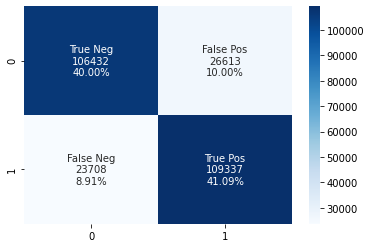

In [ ]:
# Creating and storing confusion matrix
pathconf = '/content/drive/My Drive/Project/images/CFMatrix/cfmatrix_'+str(hl1_dim)+'_'+str(lr)+'_'+str(batch_size)+'_'+str(n_epochs)+'.png'

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
a = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

figure = a.get_figure()    
figure.savefig(pathconf, dpi=400)

In [ ]:
  fpr, tpr, thresholds = roc_curve(test_true,test_preds, pos_label=1)
  precision, recall, _ = precision_recall_curve(test_true, test_preds)
  auc_roc = auc(fpr, tpr)

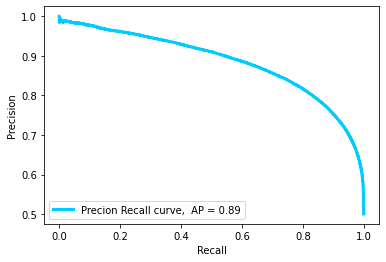

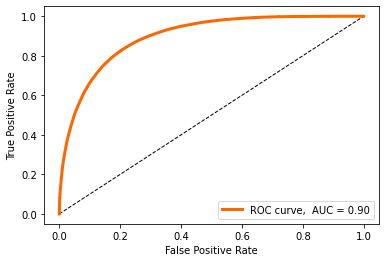

In [ ]:
# Creating and storing ROC and precion recall curves 
pathpr = '/content/drive/My Drive/Project/images/PRCurves/prcurve_'+str(hl1_dim)+'_'+str(lr)+'_'+str(batch_size)+'_'+str(n_epochs)+'.png'
pathroc = '/content/drive/My Drive/Project/images/ROCCurves/racurve_'+str(hl1_dim)+'_'+str(lr)+'_'+str(batch_size)+'_'+str(n_epochs)+'.png'

# plot the model precision-recall curve
pyplot.plot(recall, precision, label='Precion Recall curve,  AP = %0.2f' %test_ap,
            color = '#00ccff',linewidth=3.0)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend(loc=3)
pyplot.savefig(pathpr)
pyplot.show()

# plot model roc curve
pyplot.plot([0, 1], [0, 1], 'k--', linewidth=1.0)
pyplot.plot(fpr, tpr, label='ROC curve,  AUC = %0.2f' %auc_roc, color='#ff6600', 
            linewidth=3.0)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend(loc=4)
pyplot.savefig(pathroc)
pyplot.show()

<h3> Hyperparameter tuning: </h3>
As shown above first of all we have stored the results.
The reason behind that is because our model is taking much time for single iteration.<br>
I have stored values in CSV fromat. <br>
Now we are fetching values for those different hyperparameters and plotting <b>PR</b> and <b>ROC</b> values. 

In [ ]:
from matplotlib import pyplot

In [ ]:
# For diffenrent split Rocauc and ap scores

roc_val_score_dif_split = 0.8916676006, 0.8940590986, 0.8904083035, 0.8937135005, 0.8934764525, 0.8924280704, 0.8857791774, 0.8865641424, 0.8790407612, 0.87381985
ap_score_dif_slit       = 0.8790423214, 0.8846396526, 0.880608032, 0.8830095759, 0.8825938227, 0.882650904, 0.8738578983, 0.8750665332, 0.8625354427, 0.86067389
usize = ['10','20','30','40','50','60', '70', '80', '90', '95']

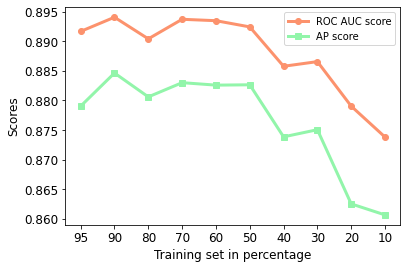

In [ ]:
usize.reverse()
pyplot.plot(usize, roc_val_score_dif_split, label='ROC AUC score',marker='o' ,color = '#fc926d',linewidth=3.0)
pyplot.plot(usize, ap_score_dif_slit, label='AP score',marker='s' ,color = '#92f5aa',linewidth=3.0)
pyplot.xlabel('Training set in percentage',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(usize)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10 
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()

In [ ]:
# fluctuatiuon in the score by changing the epoch 

valrocauc = [0.890139009,0.890815185,0.889367794,0.892475344,0.892955688,
             0.895268079,0.895390682,0.895714964,0.894352636,0.896564975,
             0.896786191,0.896511284,0.896907541,0.897584924,0.898296043,
             0.896876774,0.898871379,0.898824045,0.898350801,0.899520315,
             0.898939595,0.898228291,0.89886052,0.899088604,0.898206341,0.899219514]

valapscore = [0.88006891,0.880651104,0.878104226,0.882508134,0.883160622,
              0.885906417,0.886955786,0.887900211,0.886278583,0.88892052,
              0.888975524,0.888846114,0.889281062,0.889321064,0.890519149,
              0.887808481,0.891745116,0.89126566,0.890431978,0.892186512,
              0.890758317,0.889681969,0.890166544,0.891626466,0.890254931,0.891710797]    
epoch = list(range(5,31))


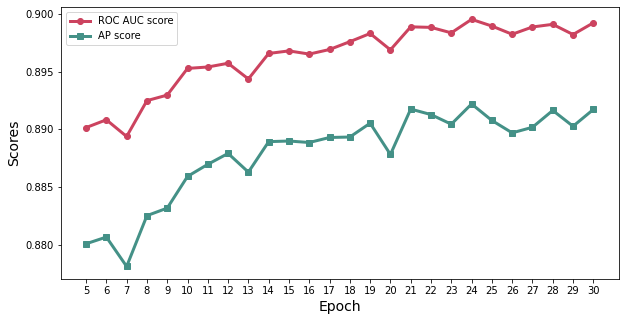

In [ ]:
# comaparision 
pyplot.figure(figsize=[10, 5])
pyplot.plot(epoch, valrocauc, label='ROC AUC score',marker='o' ,color = '#cc435f',linewidth=3.0)
pyplot.plot(epoch, valapscore, label='AP score',marker='s' ,color = '#449187',linewidth=3.0)
pyplot.xlabel('Epoch',fontsize=14)
pyplot.ylabel('Scores',fontsize=14)
pyplot.xticks(epoch)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 12 
pyplot.rcParams['ytick.labelsize'] = 12
pyplot.show()

In [ ]:
# Changing in the score by varying batch size

bsize = ['1024','512','256','128','64','32']
vel_b_rocscore = [0.8832287016,0.8832287016,0.893144403, 0.893128084, 0.897921188743932, 0.888787756]
vel_b_ap = [0.8720220684,0.8720220684,0.883519304, 0.878760341, 0.88711690712422, 0.87184281]

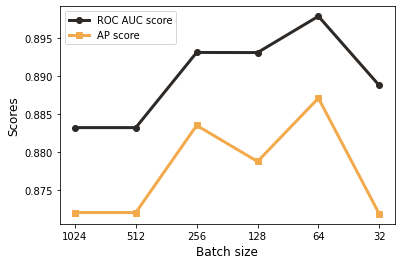

In [ ]:
# comparision AP - BS
pyplot.plot(bsize, vel_b_rocscore, label='ROC AUC score',marker='o' ,color = '#2D2926FF',linewidth=3.0)
pyplot.plot(bsize, vel_b_ap, label='AP score',marker='s' ,color = '#F2AA4CFF',linewidth=3.0)
pyplot.xlabel('Batch size',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(bsize)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10 
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()

In [ ]:
# Changing in th score by learning rate
lrate = ['0.005', '0.001', '0.01']
vel_l_rocscore = [0.883015137, 0.897665539, 0.891059064]
vel_l_ap = [0.814128562, 0.893411177, 0.880513863]


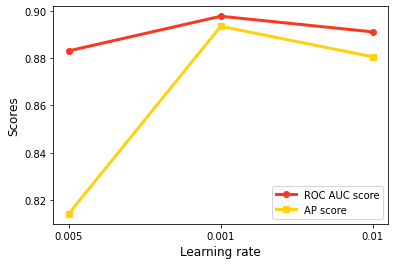

In [ ]:
pyplot.plot(lrate, vel_l_rocscore, label='ROC AUC score',marker='o' ,color = '#F93822FF',linewidth=3.0)
pyplot.plot(lrate, vel_l_ap, label='AP score',marker='s' ,color = '#FDD20EFF',linewidth=3.0)
pyplot.xlabel('Learning rate',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(lrate)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10 
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()

In [ ]:
# Unit size and respective rocauc and ap scores : hidden layer 1
usize_h1 = ['2048','1024','512','256','128','64','32']
vel_roc_h1 = [0.896542114, 0.897921188743932, 0.9001862216, 0.8942999825, 0.8868400366, 0.8885290204, 0.8963593756]
vel_ap_h1 = [0.8836053183, 0.88711690712422, 0.8902362254, 0.8893651284, 0.8780666446, 0.8819697085, 0.8840728583]

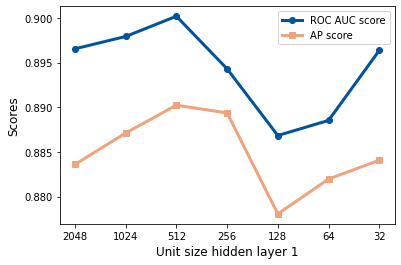

In [ ]:
pyplot.plot(usize_h1, vel_roc_h1, label='ROC AUC score',marker='o' ,color = '#00539CFF',linewidth=3.0)
pyplot.plot(usize_h1, vel_ap_h1, label='AP score',marker='s' ,color = '#EEA47FFF',linewidth=3.0)
pyplot.xlabel('Unit size hidden layer 1',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(usize_h1)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10 
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()

In [ ]:
# Unit size and respective rocauc and ap scores : hidden layer 2 
usize_h2 = ['1024','512','256','128','64','32','16']
vel_roc_h2 = [0.8998547537, 0.897921188743932, 0.8915346457, 0.9007150945, 0.89809667, 0.8891361939, 0.8891584963]
vel_ap_h2 = [0.8883510413, 0.88711690712422,0.8785202589, 0.8889612497, 0.8871189043, 0.8839932094, 0.8825620807]

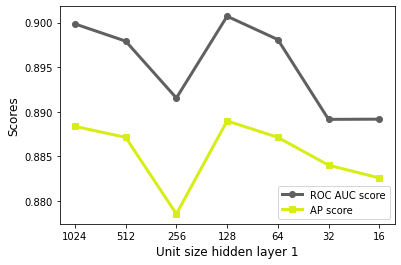

In [ ]:
pyplot.plot(usize_h2, vel_roc_h2, label='ROC AUC score',marker='o' ,color = '#606060FF',linewidth=3.0)
pyplot.plot(usize_h2, vel_ap_h2, label='AP score',marker='s' ,color = '#D6ED17FF',linewidth=3.0)
pyplot.xlabel('Unit size hidden layer 1',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(usize_h2)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10 
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()

In [ ]:
# Unit size and respective rocauc and ap scores : hidden layer 3
usize_h3 = ['512','256','128','64','32','16', '8']
vel_roc_h3 = [0.8981240487, 0.897921188743932, 0.8920384459, 0.8881123094, 0.8905081619, 0.89507149, 0.8892]
vel_ap_h3 = [0.8860755092, 0.88711690712422, 0.8882083679, 0.8803461809, 0.8765993142, 0.8842077653, 0.8763]

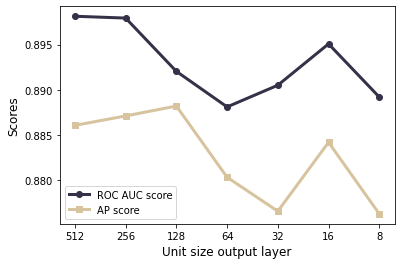

In [ ]:
pyplot.plot(usize_h3, vel_roc_h3, label='ROC AUC score',marker='o' ,color = '#343148FF',linewidth=3.0)
pyplot.plot(usize_h3, vel_ap_h3, label='AP score',marker='s' ,color = '#D7C49EFF',linewidth=3.0)
#pyplot.plot(usize, tr_u_rocsocre, label='training set',marker='D' ,color = '#ea907a',linewidth=3.0)
pyplot.xlabel('Unit size output layer',fontsize=12)
pyplot.ylabel('Scores',fontsize=12)
pyplot.xticks(usize_h3)
pyplot.legend()
pyplot.rcParams['xtick.labelsize'] = 10
pyplot.rcParams['ytick.labelsize'] = 10
pyplot.show()